In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Options Trading Price Prediction and Market Direction Analysis**

**Options trading** involves financial contracts that give buyers the right (but not the obligation) to
buy or sell an underlying asset (e.g., stocks) at a predetermined price (strike price) within a
specific time frame (until expiration).

In Simpler words, Options trading is how investors can speculate on the future direction of the
overall stock market or individual securities, like stocks or bonds. Options contracts give you the
choice—but not the obligation—to buy or sell an underlying asset at a specified price by a
specified date.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
!pip install xgboost pandas scikit-learn
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import shap

## Dataset Preperation

In [12]:
file = "/content/drive/My Drive/Yolov8/options/tsla_2019_2022.csv"
#dataset = dataset_prep(file)
dataset = pd.read_csv(file)
dataset.columns = dataset.columns.str.strip().str.replace(r"[\[\]]", "", regex=True)

<ipython-input-12-2315eba0273a>:3: DtypeWarning: Columns (8,9,10,11,12,15,17,18,20,21,23,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file)


In [13]:
dataset.columns

Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')

* For this project, we are using a Kaggle dataset of Tesla options chain end of day quotes ranging
from 01-2019 to 12-2022. Each row represents the information associated with one contract's
strike price and a given expiration date. It contains the entire option chain (all available option
contracts for all expirations) for each business day between Q1 2019 and Q4 2022.

* This dataset contains data for American options, which can be exercised on or before expiration
data. This is unlike European options contracts, which can only be exercised on the expiration
date.

* Our dataset consists of numerous attributes related to options trading. Here are some important
features:

### Time Features  
* QUOTE_UNIXTIME  
Time of the quote in UNIX timestamp
format.
* QUOTE_DATE and QUOTE_TIME_HOURS  
Date and time components of the quote,
useful for identifying market trends across
different times of the day.

### Market Prices  
* UNDERLYING_LAST  
The last recorded price of the underlying
asset (e.g., stock).
* STRIKE  
The strike price of the option contract.

### Option Greeks  
* C_DELTA, P_DELTA  
Sensitivity of the option price to small
changes in the underlying asset price (for call
and put options).
* C_GAMMA, P_GAMMA  
Measures the rate of change of delta.
* C_VEGA, P_VEGA  
Sensitivity of the option price to changes in
implied volatility.
* C_THETA, P_THETA  
Sensitivity to the passage of time (time
decay).
* C_RHO, P_RHO  
Sensitivity to changes in the risk-free
interest rate.

### Volume and Implied Volatility  
* C_IV, P_IV  
Implied volatility for call and put options.
* C_VOLUME, P_VOLUME  
Volume of options traded for both calls and
puts.

In [14]:
def dataset_prep(data):
    data.replace(" ", np.nan, inplace=True)
    #Calculating Moneyness and Converting Days to Expiration
    data['Moneyness'] = (data['UNDERLYING_LAST'] - data['STRIKE']) / data['UNDERLYING_LAST']
    data['DTE'] = data['DTE'] * 24 * 60 * 60

    #Ensures that option Greek values (for both calls and puts) are of type float, which is necessary for calculations and avoiding data type issues.
    data['C_VEGA'] = data['C_VEGA'].astype("float")
    data['C_THETA'] = data['C_THETA'].astype("float")
    data['C_DELTA'] = data['C_DELTA'].astype("float")
    data['C_GAMMA'] = data['C_GAMMA'].astype("float")
    data['C_LAST'] = data['C_LAST'].astype("float")
    data['P_VEGA'] = data['P_VEGA'].astype("float")
    data['P_THETA'] = data['P_THETA'].astype("float")
    data['P_DELTA'] = data['P_DELTA'].astype("float")
    data['P_GAMMA'] = data['P_GAMMA'].astype("float")
    data['P_LAST'] = data['P_LAST'].astype("float")

    #Calculating Additional Option Ratios and Metrics
    data['Vega_Theta_Ratio_C'] = data['C_VEGA'] / (data['C_THETA'].replace(0, 1))
    data['Delta_Gamma_C'] = data['C_DELTA'] * data['C_GAMMA']

    data['Vega_Theta_Ratio_P'] = data['P_VEGA'] / (data['P_THETA'].replace(0, 1))
    data['Delta_Gamma_P'] = data['P_DELTA'] * data['P_GAMMA']

    # Calculates a 30-day rolling standard deviation of daily returns, annualized by multiplying by the square root
    #of 252 (assumed trading days per year), then merges this back into the main dataset.
    data['QUOTE_DATE'] = pd.to_datetime(data['QUOTE_DATE'])
    daily_prices = data.groupby('QUOTE_DATE')['UNDERLYING_LAST'].last()
    daily_returns = daily_prices.pct_change()
    daily_volatility = daily_returns.rolling(window=30).std() * (252**0.5)  # 252 trading days in a year
    data = data.merge(daily_volatility.rename('Historical_Volatility'), left_on='QUOTE_DATE', right_index=True, how='left')

    #Adds 5-day and 20-day moving averages of the underlying asset price to capture short- and medium-term trends.
    data['UNDERLYING_5d_MA'] = data['UNDERLYING_LAST'].rolling(window=5).mean()
    data['UNDERLYING_20d_MA'] = data['UNDERLYING_LAST'].rolling(window=20).mean()

    UNDERLYING_5d_MA = daily_returns.rolling(window=5).mean()
    data = data.merge(daily_volatility.rename('UNDERLYING_5d_MA'), left_on='QUOTE_DATE', right_index=True, how='left')
    data['UNDERLYING_5d_MA'] = data['UNDERLYING_5d_MA_x']

    UNDERLYING_20d_MA = daily_returns.rolling(window=20).mean()
    data = data.merge(daily_volatility.rename('UNDERLYING_20d_MA'), left_on='QUOTE_DATE', right_index=True, how='left')
    data['UNDERLYING_20d_MA'] = data['UNDERLYING_20d_MA_x']

    #Drops redundant or unnecessary columns to streamline the dataset for model input.
    columns_to_drop = ['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_TIME_HOURS', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'STRIKE_DISTANCE_PCT',  'C_SIZE', 'P_SIZE','UNDERLYING_5d_MA_y',	'UNDERLYING_20d_MA_y','UNDERLYING_5d_MA_x',	'UNDERLYING_20d_MA_x']
    data = data.drop(columns_to_drop, axis = 1)

    return data

In [15]:
dataset_cleaned = dataset_prep(dataset)
dataset_cleaned.head()

,QUOTE_DATE,UNDERLYING_LAST,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,...,P_VOLUME,STRIKE_DISTANCE,Moneyness,Vega_Theta_Ratio_C,Delta_Gamma_C,Vega_Theta_Ratio_P,Delta_Gamma_P,Historical_Volatility,UNDERLYING_5d_MA,UNDERLYING_20d_MA
0,2019-05-01,233.98,172800.0,0.98465,0.00055,0.00752,-0.34320,0.009040,3.383060,1.000000,...,147.000000,104.0,0.444397,-0.021911,0.000542,-0.047179,-2.130000e-08,0.434078,NaN,NaN
1,2019-05-01,233.98,172800.0,0.98371,0.00067,0.00812,-0.34236,0.009890,3.189620,NaN,...,12.000000,99.0,0.423028,-0.023718,0.000659,-0.057426,-9.810000e-08,0.434078,NaN,NaN
2,2019-05-01,233.98,172800.0,0.98458,0.00069,0.00808,-0.28478,0.010440,2.910250,1.000000,...,15.000000,94.0,0.401658,-0.028373,0.000679,-0.078746,-1.464000e-07,0.434078,NaN,NaN
3,2019-05-01,233.98,172800.0,0.99187,0.00049,0.00503,-0.12642,0.011070,2.415820,NaN,...,0.000000,89.0,0.380289,-0.039788,0.000486,-0.094881,-1.206000e-07,0.434078,NaN,NaN
4,2019-05-01,233.98,172800.0,0.99341,0.00039,0.00315,-0.08338,0.010800,2.141030,NaN,...,91.000000,84.0,0.358920,-0.037779,0.000387,-0.071575,-1.408000e-07,0.434078,233.98,NaN


## Options Price Prediction

Options Price prediction of Call and Put values

In [16]:
#Call Dataset
dataset_C = dataset_cleaned[['UNDERLYING_LAST', 'DTE', 'C_IV', 'C_LAST', 'C_VOLUME',
         'Moneyness','Vega_Theta_Ratio_C', 'Delta_Gamma_C', 'Historical_Volatility','UNDERLYING_5d_MA','UNDERLYING_20d_MA','STRIKE']] #''C_VEGA', 'C_THETA', 'C_DELTA', 'C_GAMMA'
dataset_C = dataset_C.dropna(subset=['C_VOLUME'])
dataset_C = dataset_C.dropna(subset=['C_IV'])
dataset_C = dataset_C.dropna(subset=['Historical_Volatility'])
dataset_C = dataset_C.dropna(subset=['UNDERLYING_5d_MA'])
dataset_C = dataset_C.dropna(subset=['UNDERLYING_20d_MA'])

#Put dataset
dataset_P = dataset_cleaned[['UNDERLYING_LAST', 'DTE', 'P_IV', 'P_LAST', 'P_VOLUME',
         'Moneyness','Vega_Theta_Ratio_P', 'Delta_Gamma_P', 'Historical_Volatility','UNDERLYING_5d_MA','UNDERLYING_20d_MA','STRIKE']]
dataset_P = dataset_P.dropna(subset=['P_VOLUME'])
dataset_P = dataset_P.dropna(subset=['P_IV'])
dataset_P = dataset_P.dropna(subset=['Historical_Volatility'])
dataset_P = dataset_P.dropna(subset=['UNDERLYING_5d_MA'])
dataset_P = dataset_P.dropna(subset=['UNDERLYING_20d_MA'])

**The data were filtered so that in the analysis were used only options
that had a maturity of less than 1 year, a moneyness (S / K) less than 1.7
and a premium greater than 1**

In [17]:
import numpy as np

# Assuming the risk-free rate is 5% (adjust this value as needed)
def dataFiltering(data, CorP):
    risk_free_rate = 0.05

    # Calculate Moneyness
    data['Moneyness'] = data['UNDERLYING_LAST'] / data['STRIKE']

    # Convert DTE to days if it's in another unit (e.g., seconds)
    # Assuming DTE is already in days, we filter directly
    filtered_data = data[(data['DTE'] < 365 * 24 * 60 * 60) &
                        (data['Moneyness'] < 1.7) &
                        (data[CorP + '_LAST'] > 1)]

    return filtered_data

In [18]:
dataset_C = dataFiltering(dataset_C, 'C')
print(len(dataset_C))

dataset_P = dataFiltering(dataset_P, 'P')
print(len(dataset_P))

1055527
1010701


### Training the Model on dataset

In [19]:
y_C = dataset_C['C_LAST']
X_C = dataset_C.drop(columns=['C_LAST'])
model = None
def train_model(X,y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Initialize models with hyperparameters
    models = {
        #'Linear Regression': LinearRegression(),
        #'Ridge Regression': Ridge(alpha=1.0),
        #'Lasso Regression': Lasso(alpha=0.01),
        #'Random Forest (n=50)': RandomForestRegressor(n_estimators=50, random_state=42),
        #'Random Forest (n=100)': RandomForestRegressor(n_estimators=100, random_state=42),
        #'Random Forest (n=200)': RandomForestRegressor(n_estimators=200, random_state=42),
        #'Random Forest (n=200)': RandomForestRegressor(n_estimators=300, random_state=42),
        #'Gradient Boosting (depth=3)': GradientBoostingRegressor(max_depth=3, n_estimators=100, random_state=42),
        #'Gradient Boosting (depth=5)': GradientBoostingRegressor(max_depth=5, n_estimators=100, random_state=42),
        #'Gradient Boosting (depth=8)': GradientBoostingRegressor(max_depth=8, n_estimators=100, random_state=42),
        #'Gradient Boosting (depth=12)': GradientBoostingRegressor(max_depth=12, n_estimators=100, random_state=42),
        'X Gradient Boosting':xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,max_depth=5,alpha=10,n_estimators=100)
    }


    # Loop over the models
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        train_rmse_scores = []
        val_rmse_scores = []
        train_index = 0.8
        val_index=0.2

        # Fit the model
        model.fit(X_train, y_train)

        # Predict on training set and validation set
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate RMSE for training and validation sets
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        # Append RMSE to list for later averaging
        train_rmse_scores.append(train_rmse)
        val_rmse_scores.append(val_rmse)

        # Calculate mean RMSE for training and validation
        mean_train_rmse = np.mean(train_rmse_scores)
        mean_val_rmse = np.mean(val_rmse_scores)

        # Output the results
        print(f"{model_name} Training RMSE: {mean_train_rmse:.2f}")
        print(f"{model_name} Validation RMSE: {mean_val_rmse:.2f}\n")
    return model, X_val

In [20]:
y_C = dataset_C['C_LAST']
X_C = dataset_C.drop(columns=['C_LAST'])
model_C, X_C_val = train_model(X_C,y_C)

y_P = dataset_P['P_LAST']
X_P = dataset_P.drop(columns=['P_LAST'])
model_P, X_P_val = train_model(X_P,y_P)

Evaluating X Gradient Boosting...
X Gradient Boosting Training RMSE: 34.50
X Gradient Boosting Validation RMSE: 35.03

Evaluating X Gradient Boosting...
X Gradient Boosting Training RMSE: 42.20
X Gradient Boosting Validation RMSE: 41.90



###Feature Importance

In [23]:
import shap

def featureimportance(X_val,model):
    # Initialize the TreeExplainer with the trained XGB MODEL
    explainer = shap.TreeExplainer(model)
    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_val)

    # Display a summary plot of SHAP values
    #GLOBAL FEATURE IMPORTANCE
    shap.summary_plot(shap_values, X_val, feature_names=X_C.columns)

    #ndividual SHAP Value Plot (for a Single Prediction)
    # SHAP force plot for a single prediction (e.g., the first sample in X_test)
    shap.initjs()  # Load JS visualization tools
    shap.force_plot(explainer.expected_value, shap_values[0], X_val[0], feature_names=X_C.columns)

    shap.initjs()  # Load JS visualization tools
    shap.force_plot(explainer.expected_value, shap_values[0], X_val[100], feature_names=X_C.columns)

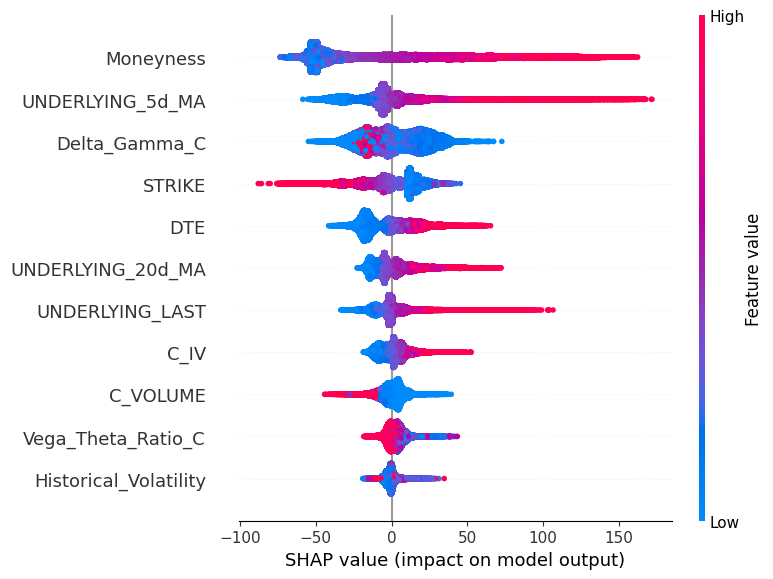

In [24]:
#For Call Predictions
featureimportance(X_C_val,model_C)

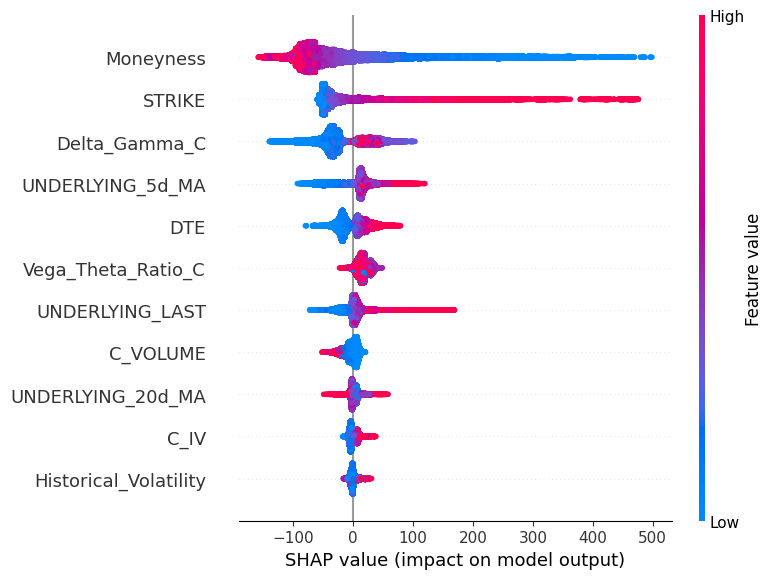

In [25]:
#For Put Predictions
featureimportance(X_C_val,model_P)

##Market Direction

In [26]:
def get_market_dir(dataset):
    unique_values =  dataset["QUOTE_DATE"].unique()
    prices = dataset.groupby('QUOTE_DATE')['UNDERLYING_LAST'].tail(1)
    weekly_compare = (prices.shift(-7) > prices)
    weekly_compare = weekly_compare.reset_index(drop=True)
    weekly_compare_equal = (prices.shift(-7) == prices)
    weekly_compare_equal = weekly_compare_equal.reset_index(drop=True)
    market_dir_col = np.zeros((dataset.shape[0]))
    dataset["MARKET_DIR"] = market_dir_col
    for i in range(0, unique_values.shape[0]):
        if(weekly_compare[i] == True):
            market_dir = 1 #(bullish)
        elif(weekly_compare[i] == False):
            if(weekly_compare_equal[i] == True):
                market_dir = 2
            else:
                market_dir = 0

        dataset.loc[dataset["QUOTE_DATE"] == unique_values[i], "MARKET_DIR"] = market_dir

get_market_dir(dataset_cleaned)

In [27]:
def dataFiltering_MD(data):
    risk_free_rate = 0.05

    # Calculate Moneyness
    data['Moneyness'] = data['UNDERLYING_LAST'] / data['STRIKE']
    # Convert DTE to days if it's in another unit (e.g., seconds)
    # Assuming DTE is already in days, we filter directly
    filtered_data = data[(data['DTE'] < 365 * 24 * 60 * 60) &
                        (data['Moneyness'] < 1.7)]

    return filtered_data


In [28]:
dataset_MD = dataFiltering_MD(dataset_cleaned)
len(dataset)

2659259

In [ ]:
y = dataset_MD['MARKET_DIR']
X = dataset_MD.drop(columns=['MARKET_DIR','QUOTE_DATE'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Instantiate and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))